In [172]:
import pandas as pd
import os
import os.path as osp
import matplotlib.pyplot as plt
from google.transit import gtfs_realtime_pb2
from datetime import datetime

In [27]:
path = 'static_gtfs'
routes = pd.read_csv(osp.join(path,'routes.txt'),sep=',', low_memory=False)
shapes = pd.read_csv(osp.join(path,'shapes.txt'),sep=',', low_memory=False)
stop_times = pd.read_csv(osp.join(path,'stop_times.txt'),sep=',', low_memory=False)
stops = pd.read_csv(osp.join(path,'stops.txt'),sep=',', low_memory=False)
trips = pd.read_csv(osp.join(path,'trips.txt'),sep=',', low_memory=False)

In [45]:
display(routes.head(2))
display(shapes.head(2))
display(stop_times.head(2))
display(stops.head(2))
display(trips.head(2))

,agency_id,route_id,route_short_name,route_long_name,route_type,route_desc,route_color,route_text_color,route_sort_order
0,BKK,0050,5,NaN,3,"Pasaréti tér / Rákospalota, Kossuth utca",009EE3,FFFFFF,20
1,BKK,0070,7,NaN,3,"Albertfalva vasútállomás / Újpalota, Nyírpalot...",009EE3,FFFFFF,23


,shape_id,shape_pt_sequence,shape_pt_lat,shape_pt_lon,shape_dist_traveled
0,0976,11601,47.474042,19.046862,0.0
1,0976,11602,47.474061,19.046866,2.0


,trip_id,stop_id,arrival_time,departure_time,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
0,C0418310,F04181,08:03:00,08:03:00,0,NaN,NaN,NaN,0.0
1,C0418310,F04526,08:06:00,08:06:00,1,NaN,NaN,NaN,160.0


,stop_id,stop_name,stop_lat,stop_lon,stop_code,location_type,location_sub_type,parent_station,wheelchair_boarding
0,002133,"Örs vezér tere M+H, déli tárolótér",47.500366,19.135700,002133,NaN,NaN,NaN,NaN
1,002138,Kőbánya alsó vasútállomás,47.483139,19.127891,002138,NaN,NaN,NaN,2.0


,route_id,trip_id,service_id,trip_headsign,direction_id,block_id,shape_id,wheelchair_accessible,bikes_allowed
0,8140,C0418310,C04183AHPMAA-011,"Soroksár, Molnár-sziget",0,C04183_8140_1_5,Y701,1.0,1.0
1,8140,C0418311,C04183AHPMAA-011,Csepel-Királyerdő,1,C04183_8140_1_6,Y702,1.0,1.0


In [152]:
class DynamicGTFS:
    def __init__(self,folder='dynamic_gtfs',name='feed_20251009_213104'):
        feed = gtfs_realtime_pb2.FeedMessage()
        with open(osp.join(folder,f'{name}.pb'), "rb") as f:
            feed.ParseFromString(f.read())

        self.timestamp = feed.header.timestamp
        self.vehicles = feed.entity

In [158]:
dyn = DynamicGTFS()
dyn.vehicles[1]

id: "VehiclePosition-BKK_101"
vehicle {
  trip {
    trip_id: "D0408916480"
    start_date: "20251009"
    schedule_relationship: SCHEDULED
    route_id: "1290"
  }
  position {
    latitude: 47.5076103
    longitude: 19.0246162
    bearing: 274
    speed: 0
  }
  current_stop_sequence: 0
  current_status: STOPPED_AT
  timestamp: 1760038242
  stop_id: "F00412"
  vehicle {
    id: "101"
    label: "Kurucles"
    license_plate: "AADI604"
  }
}

In [173]:
class StaticGTFS:
    def __init__(self,path='static_gtfs'):
            self.routes = None
            self.shapes = None
            self.stop_times = None
            self.stops = None
            self.trips = None
    
    def plot_map(self,ax,c='black'):
        ax.scatter(self.stops['stop_lon'], self.stops['stop_lat'], s=5, c=c, alpha=0.7)
        for _, group in self.shapes.groupby("shape_id"):
            group = group.sort_values("shape_pt_sequence")
            ax.plot(group["shape_pt_lon"], group["shape_pt_lat"], linewidth=0.5, c=c)

    def plot_shape(self,ax,shape_id,c):
        shape = shapes[shapes["shape_id"] == shape_id].sort_values("shape_pt_sequence")
        ax.plot(shape["shape_pt_lon"], shape["shape_pt_lat"], linewidth=0.5, c=c)
    
    def plot_stops(self,ax,stop_ids,c):
        stops = self.stops[self.stops["stop_id"].isin(stop_ids)]
        ax.scatter(stops["stop_lon"], stops["stop_lat"], c=c, s=5, alpha=0.7)

    def plot_trip(self,ax,trip_id,c):
        self.plot_stops(ax,self.stop_ids_of_trip(trip_id),c)
        self.plot_shape(ax,self.shape_id_of_trip(trip_id),c)

    def stop_ids_of_trip(self,trip_id:str) -> list[str]:
        return self.stops_of_trip(trip_id)['stop_id'].tolist()
    
    def shape_id_of_trip(self,trip_id:str) -> str:
        return trips[trips['trip_id'] == trip_id]['shape_id'].iloc[0]


    def where_is(self, vehicle):
        if vehicle.vehicle.trip.trip_id:
            trip_id = vehicle.vehicle.trip.trip_id
            current_stop_seq = vehicle.vehicle.current_stop_sequence
            timestamp = vehicle.vehicle.timestamp  # vehicle timestamp (epoch)
            time_str = datetime.fromtimestamp(timestamp).strftime("%H:%M:%S")


            # Get stops of the trip sorted by sequence
            stops_of_trip = self.stops_of_trip(trip_id)
            
            if current_stop_seq == 0:
                # Vehicle has not reached first stop yet
                next_stop = stops_of_trip.iloc[0]
                print(f"Trip ID: {trip_id}")
                print(f"Current timestamp: {time_str}")
                print(f"Vehicle has not reached the first stop yet.")
                print(f"Next stop {next_stop.stop_id} scheduled arrival: {next_stop.arrival_time}")
            else:
                # Vehicle is between prev and next stop
                prev_stop = stops_of_trip[stops_of_trip['stop_sequence'] == current_stop_seq - 1].iloc[0]
                next_stop = stops_of_trip[stops_of_trip['stop_sequence'] == current_stop_seq].iloc[0]
                print(f"Trip ID: {trip_id}")
                print(f"Current timestamp: {time_str}")
                print(f"Vehicle is after stop {prev_stop.stop_id} and heading to stop {next_stop.stop_id}")
                print(f"Scheduled arrival times:")
                print(f"  Previous stop {prev_stop.stop_id}: {prev_stop.arrival_time}")
                print(f"  Next stop {next_stop.stop_id}: {next_stop.arrival_time}")

            

    def stops_of_trip(self,trip_id:str) -> pd.DataFrame:
        return stop_times[stop_times['trip_id'] == trip_id].sort_values('stop_sequence')


         

In [174]:
static = StaticGTFS()
static.routes = routes
static.shapes = shapes
static.stop_times = stop_times
static.stops = stops
static.trips = trips

In [178]:
static.where_is(vehicle=dyn.vehicles[3])

Trip ID: D0109516907
Current timestamp: 21:30:46
Vehicle is after stop F00979 and heading to stop 038717
Scheduled arrival times:
  Previous stop F00979: 21:29:00
  Next stop 038717: 21:31:00


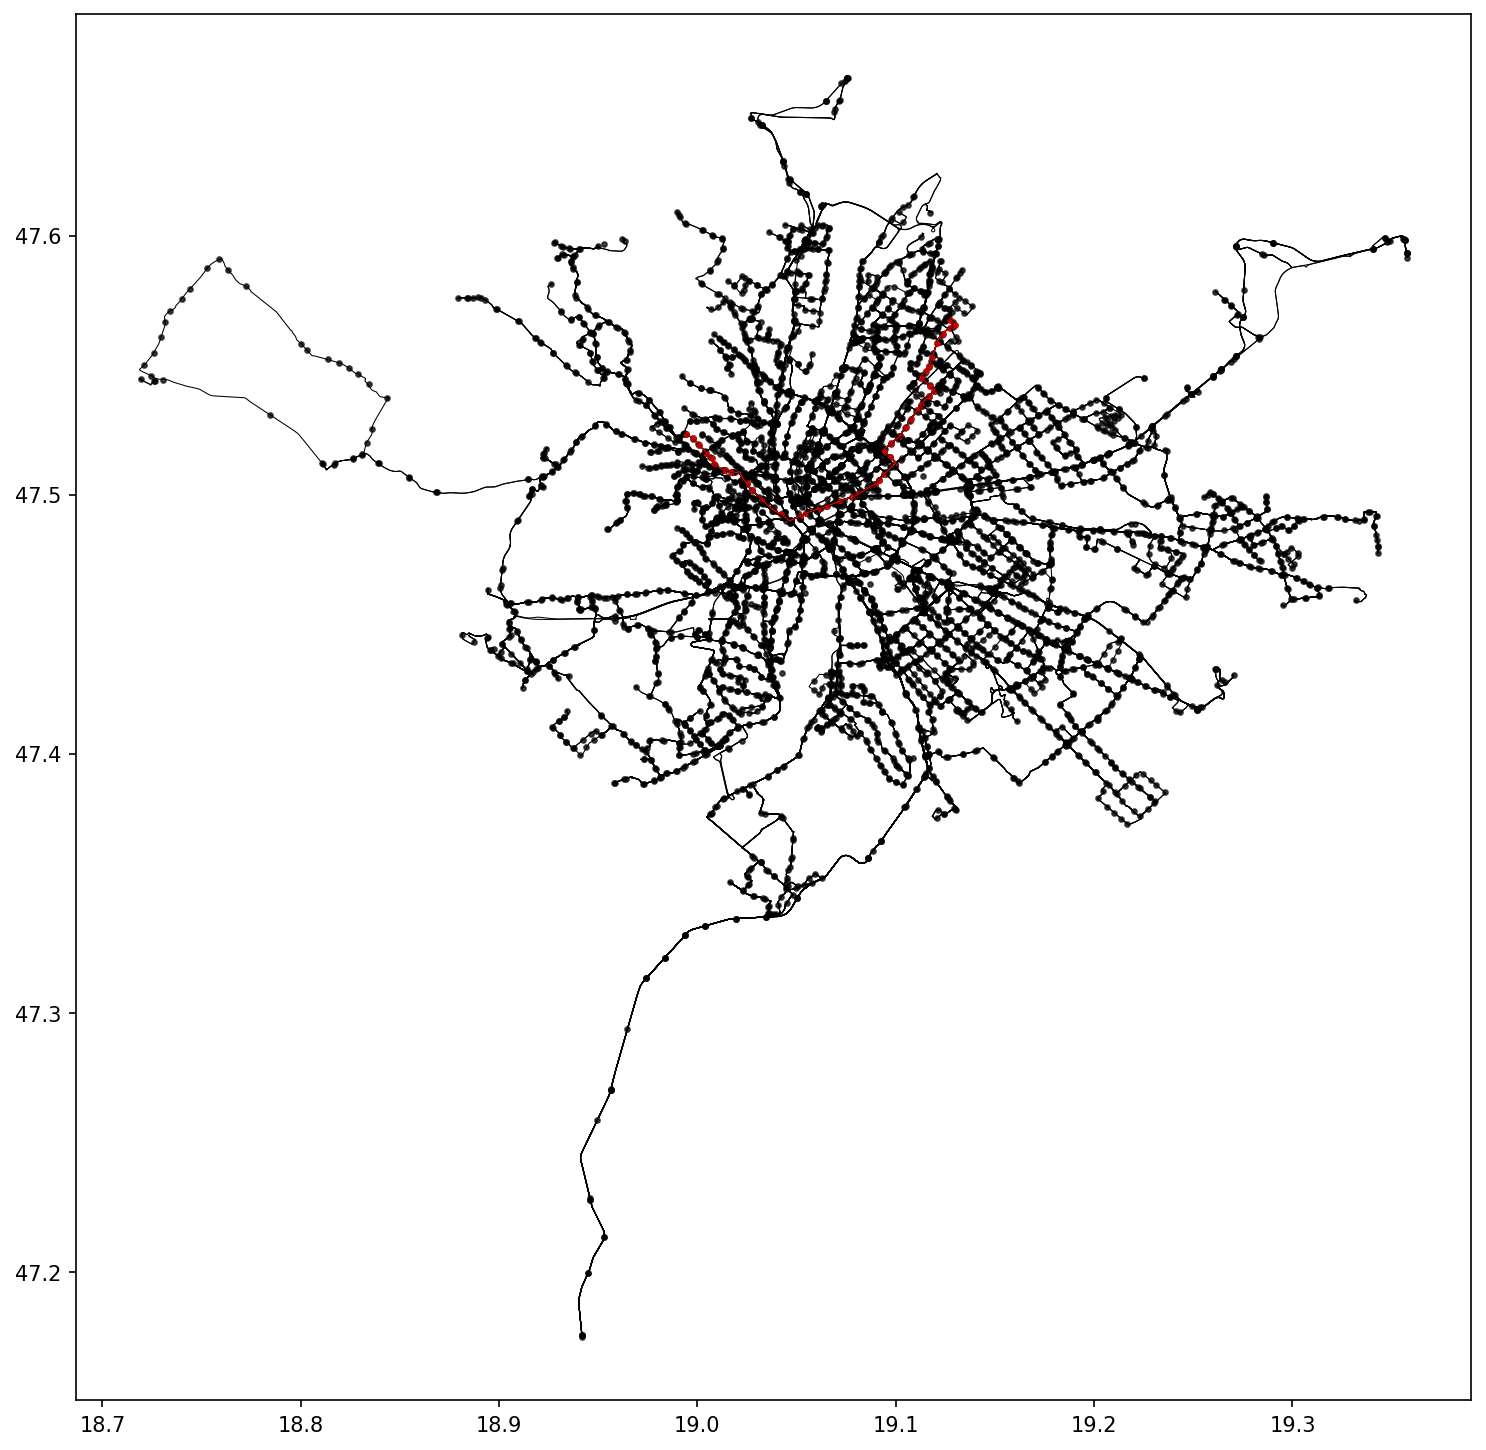

In [120]:
fig, ax = plt.subplots(1,figsize=(12,12),dpi=150)

feed.plot_map(ax)
feed.plot_trip(ax,'D0166810',c='red')